In [9]:
import pandas as pd
import os
from pathlib import Path

# print(os.getcwd())
# print(os.listdir("."))
# root = (Path.cwd() / ".." / ".." / "..").resolve()
# matches = list(root.rglob("chalki_Dimarxeio_sunedriaston_energy.csv"))
# print(matches)
df_energy = pd.read_csv('../../../chalki_Dimarxeio_sunedriaston_energy.csv')
df_tin = pd.read_csv('../../../chalki_Dimarxeio_sunedriaston_tin.csv')

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from zoneinfo import ZoneInfo

def analyze_energy_tin(
    energy_csv: str,
    tin_csv: str,
    tz: str = "Europe/Athens",
    last_days: int = 14,
    outlier_iqr_mult: float = 6.0,
    outlier_quantile: float = 0.999,
    interpolate_limit: int | None = 48,  # default: don't bridge >24h gaps
    show_tables: bool = True,
) -> dict:
    local_tz = ZoneInfo(tz)

    # ---------- load ----------
    energy_raw = pd.read_csv(energy_csv)
    tin_raw = pd.read_csv(tin_csv)

    for df in (energy_raw, tin_raw):
        if "timestamp" not in df.columns or "value" not in df.columns:
            raise ValueError("Expected CSV columns ['timestamp', 'value']")

    energy_raw["timestamp"] = pd.to_datetime(energy_raw["timestamp"], utc=True, errors="raise")
    tin_raw["timestamp"] = pd.to_datetime(tin_raw["timestamp"], utc=True, errors="raise")

    energy_raw = energy_raw.sort_values("timestamp").set_index("timestamp").rename(columns={"value": "energy_kwh"})
    tin_raw = tin_raw.sort_values("timestamp").set_index("timestamp").rename(columns={"value": "tin_c"})

    # ---------- regularize to 30-min ----------
    def reindex_30min(df: pd.DataFrame, col: str) -> pd.DataFrame:
        start = df.index.min().floor("30min")
        end = df.index.max().ceil("30min")
        idx = pd.date_range(start=start, end=end, freq="30min", tz="UTC")
        return df[[col]].reindex(idx)

    energy_r = reindex_30min(energy_raw, "energy_kwh")
    tin_r = reindex_30min(tin_raw, "tin_c")

    energy_missing_before = float(energy_r["energy_kwh"].isna().mean() * 100)
    tin_missing_before = float(tin_r["tin_c"].isna().mean() * 100)

    # ---------- interpolate ----------
    energy_f = energy_r.copy()
    tin_f = tin_r.copy()

    energy_f["energy_kwh"] = energy_f["energy_kwh"].interpolate(
        method="time", limit=interpolate_limit, limit_direction="both"
    )
    tin_f["tin_c"] = tin_f["tin_c"].interpolate(
        method="time", limit=interpolate_limit, limit_direction="both"
    )

    energy_missing_after = float(energy_f["energy_kwh"].isna().mean() * 100)
    tin_missing_after = float(tin_f["tin_c"].isna().mean() * 100)

    # ---------- clip energy outliers ----------
    e = energy_f["energy_kwh"].clip(lower=0)

    q1, q3 = e.quantile(0.25), e.quantile(0.75)
    iqr = q3 - q1
    upper_iqr = q3 + outlier_iqr_mult * iqr if pd.notna(iqr) else np.nan
    upper_q = e.quantile(outlier_quantile) if 0 < outlier_quantile < 1 else np.nan

    candidates = [v for v in (upper_iqr, upper_q) if pd.notna(v) and np.isfinite(v)]
    upper_cap = min(candidates) if candidates else float(e.max())

    clipped_mask = e > upper_cap
    n_clipped = int(clipped_mask.sum())
    pct_clipped = float(clipped_mask.mean() * 100)

    energy_f["energy_kwh"] = e.clip(upper=upper_cap)

    # ---------- overlap join ----------
    overlap_start = max(energy_f.index.min(), tin_f.index.min())
    overlap_end = min(energy_f.index.max(), tin_f.index.max())

    df_utc = energy_f.loc[overlap_start:overlap_end].join(
        tin_f.loc[overlap_start:overlap_end], how="outer"
    )

    df_local = df_utc.copy()
    df_local.index = df_local.index.tz_convert(local_tz)

    # ---------- rollups ----------
    daily = pd.DataFrame({
        "energy_kwh_day": df_local["energy_kwh"].resample("D").sum(min_count=1),
        "tin_mean_c": df_local["tin_c"].resample("D").mean(),
        "tin_min_c": df_local["tin_c"].resample("D").min(),
        "tin_max_c": df_local["tin_c"].resample("D").max(),
    })
    daily["tin_swing_c"] = daily["tin_max_c"] - daily["tin_min_c"]

    monthly = pd.DataFrame({
        "energy_kwh_sum": df_local["energy_kwh"].resample("MS").sum(min_count=1),
        "avg_daily_energy_kwh": daily["energy_kwh_day"].resample("MS").mean(),
        "avg_tin_c": df_local["tin_c"].resample("MS").mean(),
    })

    corr_30min = float(df_local[["energy_kwh", "tin_c"]].corr().iloc[0, 1])
    corr_daily = float(daily[["energy_kwh_day", "tin_mean_c"]].dropna().corr().iloc[0, 1])

    aligned = df_local[["energy_kwh", "tin_c"]].dropna().copy()
    aligned["month"] = aligned.index.to_period("M")
    monthly_corr = aligned.groupby("month").apply(lambda g: g["energy_kwh"].corr(g["tin_c"]))
    monthly_corr_df = monthly_corr.rename("corr_energy_vs_tin").reset_index()
    monthly_corr_df["month_start"] = monthly_corr_df["month"].dt.to_timestamp()

    # ---------- lag correlation ----------
    def lagged_corr(series_x, series_y, lags):
        return pd.Series([series_x.corr(series_y.shift(-lag)) for lag in lags], index=lags)

    lags = range(-12, 13)  # -6h..+6h
    summer_mask = (aligned.index.year == 2025) & (aligned.index.month >= 6) & (aligned.index.month <= 9)

    winter_mask = (
        ((aligned.index.year == 2025) & (aligned.index.month == 12)) |
        ((aligned.index.year == 2026) & (aligned.index.month == 1))
    )

    summer_lagcorr = lagged_corr(aligned.loc[summer_mask, "energy_kwh"], aligned.loc[summer_mask, "tin_c"], lags)
    winter_lagcorr = lagged_corr(aligned.loc[winter_mask, "energy_kwh"], aligned.loc[winter_mask, "tin_c"], lags)

    # ---------- hourly profiles ----------
    dfh = df_local.copy()
    dfh["hour"] = dfh.index.hour
    hourly_profile = dfh.groupby("hour")[["energy_kwh", "tin_c"]].mean()

    hourly_summer_energy = (
        dfh.loc[(dfh.index.year == 2025) & (dfh.index.month >= 6) & (dfh.index.month <= 9)]
        .groupby("hour")["energy_kwh"]
        .mean()
    )    
    hourly_winter_energy = dfh.loc[((dfh.index.year == 2025) & (dfh.index.month == 12)) | ((dfh.index.year == 2026) & (dfh.index.month == 1))].groupby("hour")["energy_kwh"].mean()

    # ---------- plots ----------
    # A) energy daily (full energy file range) after preprocessing
    energy_local_full = energy_f.copy()
    energy_local_full.index = energy_local_full.index.tz_convert(local_tz)
    energy_daily_full = energy_local_full["energy_kwh"].resample("D").sum(min_count=1)

    plt.figure(figsize=(12,4))
    plt.plot(energy_daily_full.index, energy_daily_full.values)
    plt.xlabel(f"Date ({tz})")
    plt.ylabel("Energy (kWh/day)")
    plt.title("Energy: Daily totals (full range, after clipping/interp)")
    plt.show()

    # 1) last N days (dual axis)
    window_end = df_local.index.max()
    window_start = window_end - pd.Timedelta(days=last_days)
    w = df_local.loc[window_start:window_end]

    fig = plt.figure(figsize=(12,4))
    ax = plt.gca()
    ax.plot(w.index, w["energy_kwh"])
    ax.set_xlabel(f"Time ({tz})")
    ax.set_ylabel("Energy (kWh per 30 min)")
    ax2 = ax.twinx()
    ax2.plot(w.index, w["tin_c"])
    ax2.set_ylabel("Indoor temp (°C)")
    ax.set_title(f"Last {last_days} days: Energy vs Indoor Temp")
    fig.autofmt_xdate()
    plt.show()

    # 2) daily energy vs daily mean tin
    fig = plt.figure(figsize=(12,4))
    ax = plt.gca()
    ax.plot(daily.index, daily["energy_kwh_day"])
    ax.set_xlabel(f"Date ({tz})")
    ax.set_ylabel("Energy (kWh/day)")
    ax2 = ax.twinx()
    ax2.plot(daily.index, daily["tin_mean_c"])
    ax2.set_ylabel("Temp (°C)")
    ax.set_title("Daily Energy vs Daily Mean Indoor Temp")
    plt.show()

    # 3) scatter daily energy vs daily mean tin (season buckets)
    dsc = daily[["energy_kwh_day","tin_mean_c"]].dropna()
    m = dsc.index.month
    sm = m.isin([6,7,8,9])
    wm = m.isin([12,1,2])
    sh = ~(sm | wm)

    plt.figure(figsize=(6,5))
    plt.scatter(dsc.loc[sm,"tin_mean_c"], dsc.loc[sm,"energy_kwh_day"], label="Summer (Jun-Sep)")
    plt.scatter(dsc.loc[wm,"tin_mean_c"], dsc.loc[wm,"energy_kwh_day"], label="Winter (Dec-Feb)")
    plt.scatter(dsc.loc[sh,"tin_mean_c"], dsc.loc[sh,"energy_kwh_day"], label="Shoulder")
    plt.xlabel("Daily mean indoor temp (°C)")
    plt.ylabel("Daily energy (kWh)")
    plt.title("Daily Energy vs Indoor Temp (season buckets)")
    plt.legend()
    plt.show()

    # 4) monthly totals + avg tin
    midx = monthly.index.tz_localize(None)
    fig = plt.figure(figsize=(10,4))
    ax = plt.gca()
    ax.bar(midx, monthly["energy_kwh_sum"])
    ax.set_xlabel("Month")
    ax.set_ylabel("Energy (kWh/month)")
    ax.set_title("Monthly Energy (bars) and Avg Indoor Temp (line)")
    ax2 = ax.twinx()
    ax2.plot(midx, monthly["avg_tin_c"])
    ax2.set_ylabel("Avg indoor temp (°C)")
    plt.show()

    # 5) monthly correlation
    plt.figure(figsize=(10,4))
    plt.plot(monthly_corr_df["month_start"], monthly_corr_df["corr_energy_vs_tin"])
    plt.axhline(0)
    plt.xlabel("Month")
    plt.ylabel("Corr(energy, tin) on 30-min data")
    plt.title("Monthly correlation: Energy vs Indoor Temp")
    plt.show()

    # 6) lag correlation
    plt.figure(figsize=(10,4))
    plt.plot([l*0.5 for l in summer_lagcorr.index], summer_lagcorr.values, label="Summer")
    plt.plot([l*0.5 for l in winter_lagcorr.index], winter_lagcorr.values, label="Winter")
    plt.xlabel("Lag (hours). Positive means temp later than energy.")
    plt.ylabel("Correlation")
    plt.title("Lag correlation: Energy vs Temp")
    plt.legend()
    plt.show()

    # 7) hourly profiles
    plt.figure(figsize=(10,4))
    plt.plot(hourly_profile.index, hourly_profile["energy_kwh"])
    plt.xlabel(f"Hour ({tz})")
    plt.ylabel("Avg energy (kWh per 30 min)")
    plt.title("Average hourly energy profile")
    plt.show()

    plt.figure(figsize=(10,4))
    plt.plot(hourly_profile.index, hourly_profile["tin_c"])
    plt.xlabel(f"Hour ({tz})")
    plt.ylabel("Avg indoor temp (°C)")
    plt.title("Average hourly indoor temperature profile")
    plt.show()

    plt.figure(figsize=(10,4))
    plt.plot(hourly_summer_energy.index, hourly_summer_energy.values, label="Summer")
    plt.plot(hourly_winter_energy.index, hourly_winter_energy.values, label="Winter")
    plt.xlabel(f"Hour ({tz})")
    plt.ylabel("Avg energy (kWh per 30 min)")
    plt.title("Hourly energy profile: Summer vs Winter")
    plt.legend()
    plt.show()

    stats = pd.DataFrame({
        "series": ["energy_kwh (30-min)", "tin_c (30-min)"],
        "overlap_start_utc": [df_utc.index.min(), df_utc.index.min()],
        "overlap_end_utc": [df_utc.index.max(), df_utc.index.max()],
        "rows_overlap": [len(df_utc), len(df_utc)],
        "missing_%_before_interp": [energy_missing_before, tin_missing_before],
        "missing_%_after_interp": [energy_missing_after, tin_missing_after],
        "min": [df_utc["energy_kwh"].min(), df_utc["tin_c"].min()],
        "p50": [df_utc["energy_kwh"].median(), df_utc["tin_c"].median()],
        "mean": [df_utc["energy_kwh"].mean(), df_utc["tin_c"].mean()],
        "p95": [df_utc["energy_kwh"].quantile(0.95), df_utc["tin_c"].quantile(0.95)],
        "max": [df_utc["energy_kwh"].max(), df_utc["tin_c"].max()],
    }).round(3)

    metrics = {
        "energy_outlier_upper_cap_kwh_30min": float(upper_cap),
        "energy_outliers_clipped_n": int(n_clipped),
        "energy_outliers_clipped_pct": float(pct_clipped),
        "energy_zero_pct": float((df_local["energy_kwh"] == 0).mean() * 100),
        "corr_30min": float(corr_30min),
        "corr_daily": float(corr_daily),
    }

    if show_tables:
        print("\n=== Summary (after preprocessing) ===")
        print(stats)
        print("\n=== Metrics ===")
        print(metrics)
        print("\n=== Monthly rollup (head) ===")
        print(monthly.round(3).head())
        print("\n=== Monthly correlation ===")
        print(monthly_corr_df.round(3))

    return {
        "df_local_30min": df_local,
        "daily": daily,
        "monthly": monthly,
        "monthly_corr": monthly_corr_df,
        "hourly_profile": hourly_profile,
        "summer_lagcorr": summer_lagcorr,
        "winter_lagcorr": winter_lagcorr,
        "stats": stats,
        "metrics": metrics,
    }


C:\Users\Kelsier\AppData\Local\Temp\ipykernel_17308\2741424785.py:106: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  aligned["month"] = aligned.index.to_period("M")
C:\Users\Kelsier\AppData\Local\Temp\ipykernel_17308\2741424785.py:107: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  monthly_corr = aligned.groupby("month").apply(lambda g: g["energy_kwh"].corr(g["tin_c"]))


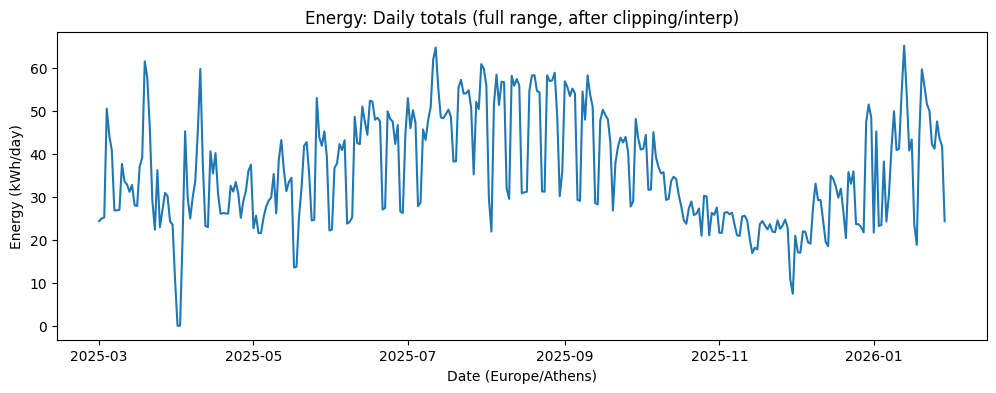

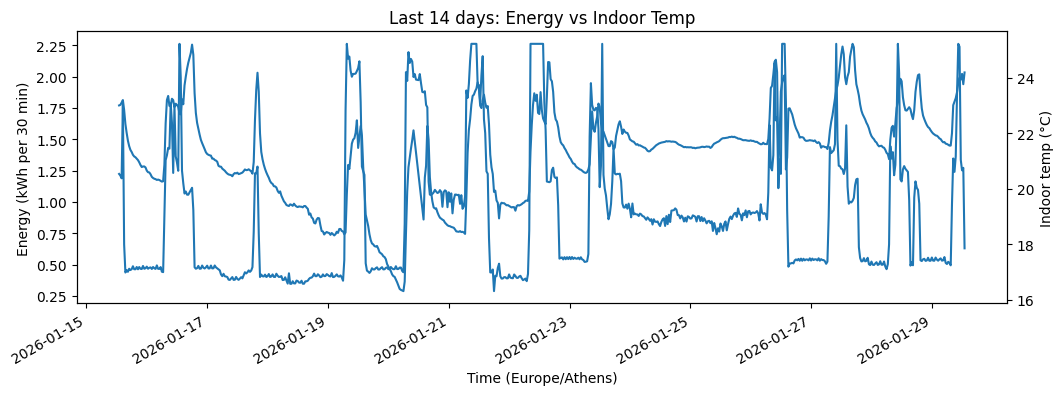

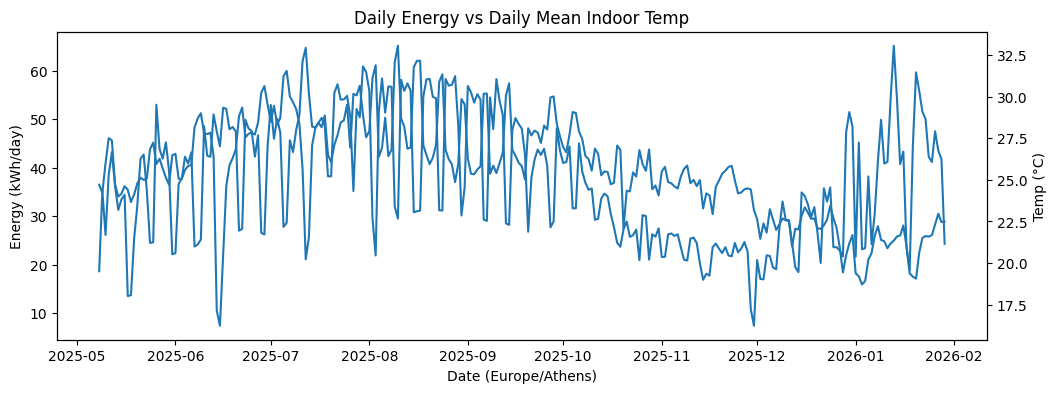

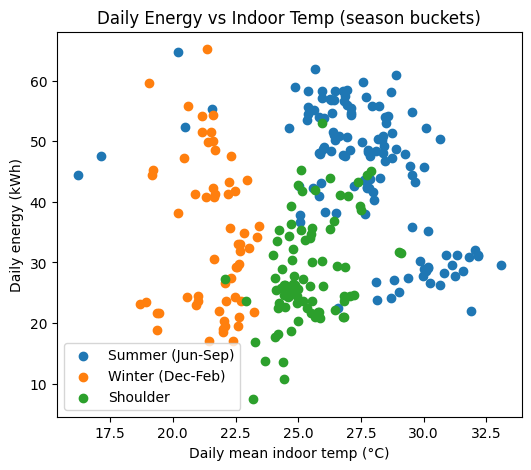

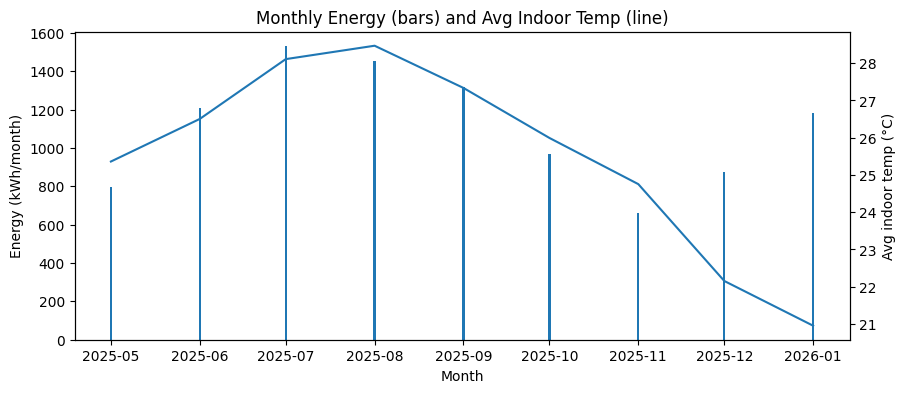

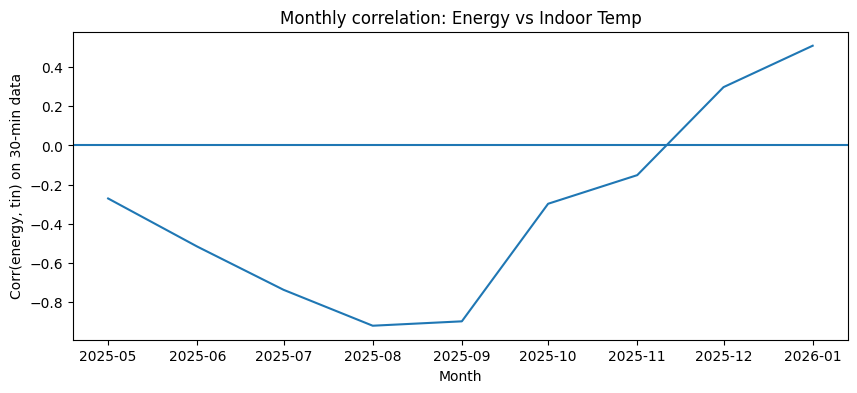

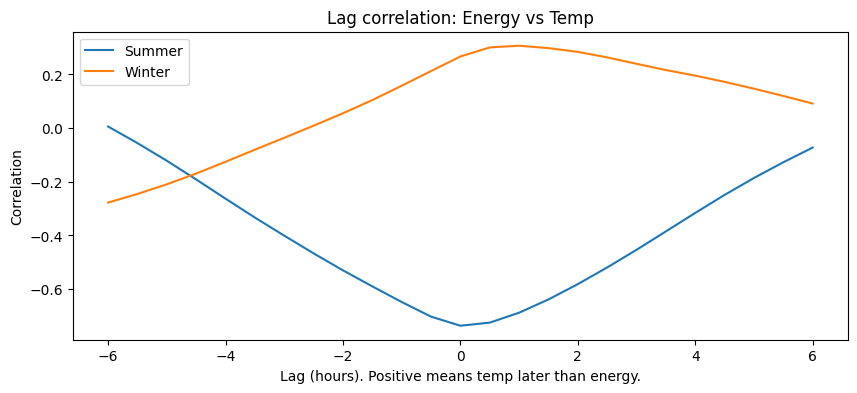

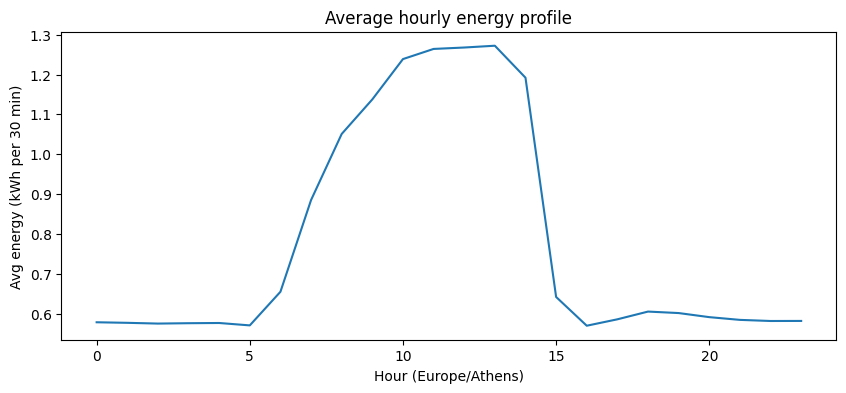

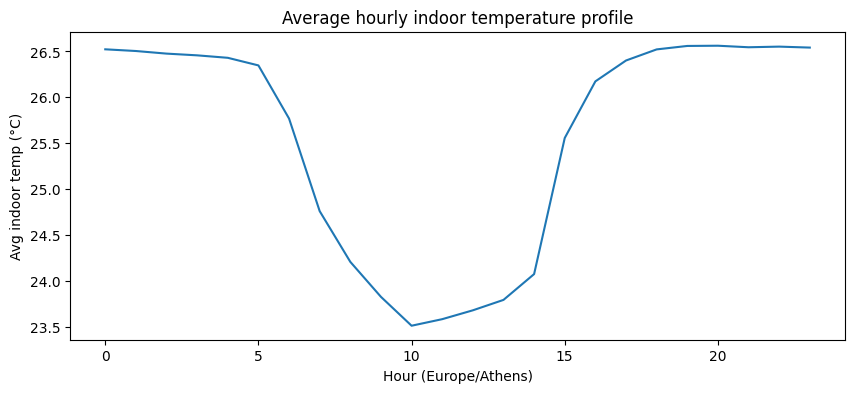

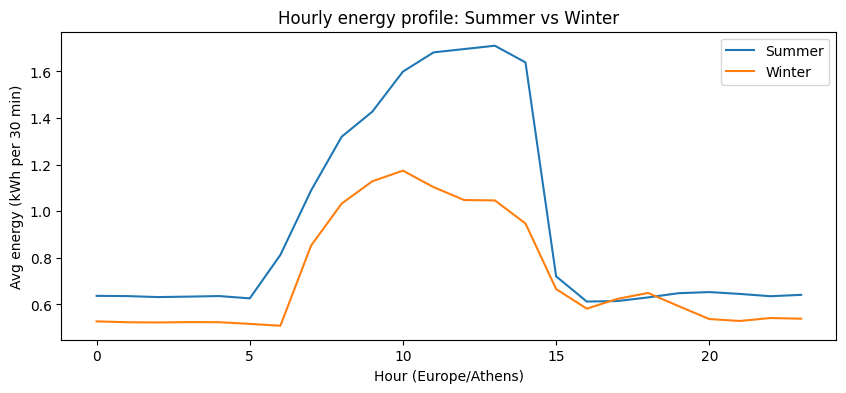


=== Summary (after preprocessing) ===
                series         overlap_start_utc           overlap_end_utc  \
0  energy_kwh (30-min) 2025-05-08 07:30:00+00:00 2026-01-29 11:00:00+00:00   
1       tin_c (30-min) 2025-05-08 07:30:00+00:00 2026-01-29 11:00:00+00:00   

   rows_overlap  missing_%_before_interp  missing_%_after_interp     min  \
0         12776                    0.000                   0.000   0.000   
1         12776                    7.498                   0.141  15.476   

      p50    mean     p95     max  
0   0.608   0.782   2.260   2.263  
1  25.599  25.554  31.376  33.557  

=== Metrics ===
{'energy_outlier_upper_cap_kwh_30min': 2.263075766019029, 'energy_outliers_clipped_n': 710, 'energy_outliers_clipped_pct': 4.421196836664799, 'energy_zero_pct': 0.939261114589856, 'corr_30min': -0.2958775045588448, 'corr_daily': 0.1258289493826161}

=== Monthly rollup (head) ===
                           energy_kwh_sum  avg_daily_energy_kwh  avg_tin_c
2025-05-01 00:00:

{'df_local_30min':                            energy_kwh      tin_c
 2025-05-08 10:30:00+03:00    0.770767  23.848551
 2025-05-08 11:00:00+03:00    0.713531  24.050532
 2025-05-08 11:30:00+03:00    0.725475  24.097346
 2025-05-08 12:00:00+03:00    0.775542  23.413720
 2025-05-08 12:30:00+03:00    0.958461  21.188075
 ...                               ...        ...
 2026-01-29 11:00:00+02:00    2.239820  24.014614
 2026-01-29 11:30:00+02:00    1.336982  23.940352
 2026-01-29 12:00:00+02:00    1.253669  24.148266
 2026-01-29 12:30:00+02:00    1.273732  23.775506
 2026-01-29 13:00:00+02:00    0.631418  24.200315
 
 [12776 rows x 2 columns],
 'daily':                            energy_kwh_day  tin_mean_c  tin_min_c  tin_max_c  \
 2025-05-08 00:00:00+03:00       18.678562   24.709233  21.188075  25.552346   
 2025-05-09 00:00:00+03:00       35.323286   24.221804  16.900314  25.978128   
 2025-05-10 00:00:00+03:00       26.162629   25.993733  25.671096  26.458931   
 2025-05-11 00:00:00+03:

In [16]:
analyze_energy_tin('../../../chalki_Dimarxeio_sunedriaston_energy.csv', '../../../chalki_Dimarxeio_sunedriaston_tin.csv')